## 1: First we import the required modules

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import time  
import copy
from torch.autograd import Variable
from torch import nn
from torchviz import make_dot, make_dot_from_trace
from torchviz import make_dot
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim
from model import Actor, Critic
import matplotlib.pyplot as plt
%matplotlib inline

## 2: Before you run the next cell make sure you have done the following:
- Downloaded the required environment for your operating system. Details in README.MD
- Extracted the enviroment and placed folder into same directory as results.ipynb
- Change the arg: "file_name" below to the correct environment path if required. 

The following cell initiates the Unity environment 

In [2]:
env = UnityEnvironment(file_name='Tennis_Linux/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 3:Now we create the brain to interact with the environment

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 4: Next cell provides a simple example of the environment and prints out the following:
- Number of Agents(brains), 
- The size of each action
- The State as a vector
- the length of the State vector

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 5: We now import the Agent and assign it a variable

The agent is a MADDPG or Deep Deterministic Policy gradient. 


The Hyperparamters below performed great with high results and steady learning curve. Feel free to play with these 

    ```
	BUFFER_SIZE = int(1e6)  # replay buffer size
    BATCH_SIZE = 1024     # minibatch size
    GAMMA = 0.99            # discount factor
    TAU = 1e-3              # for soft update of target parameters
    LR_ACTOR = 1e-4         # learning rate of the actor 
    LR_CRITIC = 1e-3        # learning rate of the critic
    WEIGHT_DECAY = 0        # L2 weight decay
	```




In [5]:
from agent import Agent

agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=4)

## 6: Lets take a look at the Actor model model
It builds an actor (policy) network that maps states -> actions
- The model  has 3 fully connected layers
- The first layer takes in the state passes it through 64 nodes with relu activation
- The second layer take the output from  first layer and passes through 32 nodes with relu activation
- The third layer takes the output from the previous layer and outputs the action size with Tanh activation
- Adam optimizer.

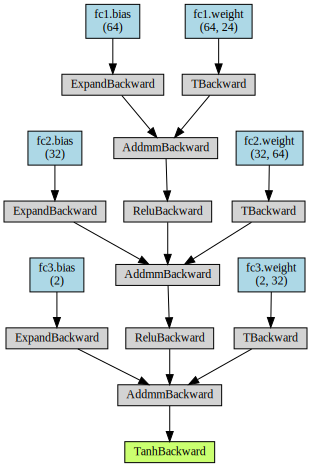

In [6]:
model = Actor(state_size, action_size, 42)
x = Variable(torch.randn(1,state_size))
y = model(x)
             
make_dot(y, params=dict(list(model.named_parameters())))

## 7: Lets take a look at the Critic model
Build a critic (value) network that maps (state, action) pairs -> Q-values.
- The model  has 4 fully connected layers
- The first layer takes the state and passes through 128 nodes with relu activation
- Then we take the output from the first layer and concactenate it with the action size
- We then pass this to second layer which forwards through 64 nodes with relu activation
- The third layer takes the output from the previous layer passes it through 32 nodes with relu activation
- The fourth layer take the previous layer outputs 1
- Adam optimizer.

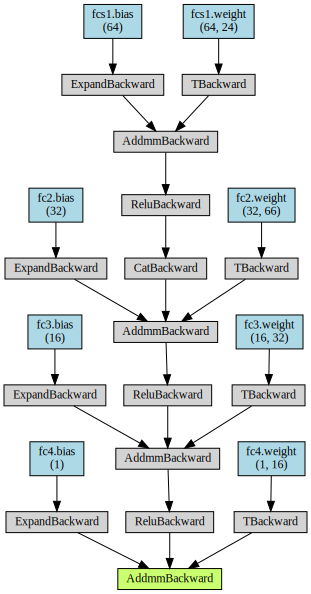

In [7]:
model = Critic(state_size, action_size, 42)
x = Variable(torch.randn(1,state_size))
z = Variable(torch.randn(1,action_size))
y = model(x, z)
             
make_dot(y, params=dict(list(model.named_parameters())))

## 8: Run the Multi-Agent Deep Deterministic Policy Gradient algorithm and training steps:

The folloing cell provides the main training function. It is solved once it reaches an average score of 30 over 100 episode.


In [8]:
def maddpg(n_episodes=1000000, max_steps=10000, multi_agent=False, multi_replay=False, split_replay=False):
    scores_mean = deque(maxlen=100)
    scores = []
    best_score = 0
    best_average_score = 0
    for i_episode in range(1, n_episodes+1):                       
        average_score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations            
        scores_agents = np.zeros(num_agents)             
        score = 0
        if multi_agent:
            agent1.reset()
            agent2.reset()
        else:
            agent1.reset()

        for step in range(max_steps):
            if multi_agent:
                actions = np.random.randn(num_agents, action_size)
                actions[0] = agent1.act(states[0])                  # select an action (for each agent)
                actions[1] = agent2.act(states[1])
            else: 
                actions = agent1.act(states)
            env_info = env.step(actions)[brain_name]     
            next_states = env_info.vector_observations   
            rewards = env_info.rewards                   
            dones = env_info.local_done
            if multi_replay:
                if split_replay:
                    agent1.step(states[0], actions[0], rewards[0], next_states[0], dones[0], step)
                    agent2.step(states[1], actions[1], rewards[1], next_states[1], dones[1], step)
                else:
                    agent1.step(states, actions, rewards, next_states, dones, step)
                    agent2.step(states, actions, rewards, next_states, dones, step)
                
            else:             
                agent1.step(states, actions, rewards, next_states, dones, step)
                
            states = next_states
            scores_agents += rewards
            if np.any(dones):
                break

        score = scores_agents.max()
        scores_mean.append(score)
        average_score = np.mean(scores_mean)
        scores.append(score)
        if score > best_score:
            best_score = score
        if average_score > best_average_score:
            best_average_score = average_score
        
        print("Episode:{}, Low Score:{:.2f}, High Score:{:.2f}, Score:{:.2f}, Best Score:{:.2f}, Average Score:{:.2f}, Best Avg Score:{:.2f}".format(i_episode, scores_agents.min(), scores_agents.max(), score, best_score, average_score, best_average_score))
        if average_score > 0.5:
            print("Episode:{}, Low Score:{:.2f}, High Score:{:.2f}, Score:{:.2f}, Best Score:{:.2f}, Average Score:{:.2f}, Best Avg Score:{:.2f}".format(i_episode, scores_agents.min(), scores_agents.max(), score, best_score, average_score, best_average_score))

            if multi_agent:
                torch.save(agent1.actor_local.state_dict(), 'checkpoint_actorma.pth')
                torch.save(agent1.critic_local.state_dict(), 'checkpoint_criticma.pth') 
                torch.save(agent2.actor_local.state_dict(), 'checkpoint_actorma.pth')
                torch.save(agent2.critic_local.state_dict(), 'checkpoint_criticma.pth')
            elif split_replay:
                torch.save(agent1.actor_local.state_dict(), 'checkpoint_actorsr.pth')
                torch.save(agent1.critic_local.state_dict(), 'checkpoint_criticsr.pth') 
                torch.save(agent2.actor_local.state_dict(), 'checkpoint_actorsr.pth')
                torch.save(agent2.critic_local.state_dict(), 'checkpoint_criticsr.pth')
            else:
                torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic.pth') 
                    

            break
    return scores

#scores = ddpg()

## MADDPG with shared Actor-Critic, ReplayMemory and Model

In [9]:
scores = maddpg(n_episodes=1000000, max_steps=10000, multi_agent=False, multi_replay=False, split_replay=False)

Episode:1, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:2, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:3, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:4, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:5, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:6, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:7, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:8, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:9, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:

/home/adaptation/Documents/MADDPG-Colaboration-Competition/agent.py:133: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode:31, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:32, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:33, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:34, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:35, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:36, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:37, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:38, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:39, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.10, Averag

Episode:103, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:104, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:105, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:106, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:107, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:108, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:109, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:110, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:111, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:174, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:175, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:176, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:177, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:178, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:179, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:180, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:181, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:182, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:245, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:246, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:247, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:248, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:249, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:250, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:251, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:252, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:253, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:316, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:317, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:318, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:319, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:320, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:321, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:322, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:323, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:324, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:387, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:388, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:389, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:390, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:391, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:392, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:393, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:394, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:395, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:458, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:459, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:460, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:461, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:462, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:463, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:464, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:465, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:466, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:529, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:530, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:531, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:532, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:533, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:534, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:535, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:536, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:537, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:600, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:601, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:602, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:603, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:604, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:605, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:606, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:607, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:608, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:671, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:672, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:673, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:674, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:675, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:676, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:677, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:678, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:679, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:742, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:743, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:744, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:745, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:746, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:747, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:748, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:749, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:750, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:813, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.19, Average Score:0.01, Best Avg Score:0.01
Episode:814, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.19, Average Score:0.01, Best Avg Score:0.01
Episode:815, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.19, Average Score:0.01, Best Avg Score:0.01
Episode:816, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.19, Average Score:0.01, Best Avg Score:0.01
Episode:817, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.19, Average Score:0.01, Best Avg Score:0.01
Episode:818, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:819, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:820, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:821, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.1

Episode:884, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:885, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:886, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:887, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:888, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:889, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:890, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:891, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.19, Average Score:0.02, Best Avg Score:0.02
Episode:892, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.19

Episode:955, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:956, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:957, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:958, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:959, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:960, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:961, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:962, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:963, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20

Episode:1026, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.04
Episode:1027, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.03, Best Avg Score:0.04
Episode:1028, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.04
Episode:1029, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.03, Best Avg Score:0.04
Episode:1030, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.03, Best Avg Score:0.04
Episode:1031, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.04
Episode:1032, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.04
Episode:1033, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.04
Episode:1034, Low Score:-0.01, High Score:0.10, Score:0.10, Best Sc

Episode:1097, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:1098, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:1099, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:1100, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:1101, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:1102, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:1103, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:1104, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:1105, Low Score:-0.01, High Score:0.00, Score:0.00, Best 

Episode:1168, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.04, Best Avg Score:0.06
Episode:1169, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.04, Best Avg Score:0.06
Episode:1170, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.04, Best Avg Score:0.06
Episode:1171, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.04, Best Avg Score:0.06
Episode:1172, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.04, Best Avg Score:0.06
Episode:1173, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.04, Best Avg Score:0.06
Episode:1174, Low Score:-0.02, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.04, Best Avg Score:0.06
Episode:1175, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.03, Best Avg Score:0.06
Episode:1176, Low Score:-0.01, High Score:0.10, Score:0.10, Best 

Episode:1239, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.09, Best Avg Score:0.09
Episode:1240, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.09, Best Avg Score:0.09
Episode:1241, Low Score:0.39, High Score:0.40, Score:0.40, Best Score:0.50, Average Score:0.10, Best Avg Score:0.10
Episode:1242, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.10, Best Avg Score:0.10
Episode:1243, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.10, Best Avg Score:0.10
Episode:1244, Low Score:0.69, High Score:0.80, Score:0.80, Best Score:0.80, Average Score:0.11, Best Avg Score:0.11
Episode:1245, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:0.80, Average Score:0.11, Best Avg Score:0.11
Episode:1246, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.80, Average Score:0.11, Best Avg Score:0.11
Episode:1247, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score

Episode:1310, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.29, Best Avg Score:0.29
Episode:1311, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.29, Best Avg Score:0.29
Episode:1312, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.70, Average Score:0.28, Best Avg Score:0.29
Episode:1313, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.28, Best Avg Score:0.29
Episode:1314, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.29, Best Avg Score:0.29
Episode:1315, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.29, Best Avg Score:0.29
Episode:1316, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.70, Average Score:0.29, Best Avg Score:0.29
Episode:1317, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.29, Best Avg Score:0.29
Episode:1318, Low Score:0.09, High Score:0.10, Score:0.10, Best Score

Episode:1381, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.70, Average Score:0.18, Best Avg Score:0.30
Episode:1382, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.18, Best Avg Score:0.30
Episode:1383, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.18, Best Avg Score:0.30
Episode:1384, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.18, Best Avg Score:0.30
Episode:1385, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.70, Average Score:0.18, Best Avg Score:0.30
Episode:1386, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.70, Average Score:0.17, Best Avg Score:0.30
Episode:1387, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.17, Best Avg Score:0.30
Episode:1388, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.17, Best Avg Score:0.30
Episode:1389, Low Score:0.09, High Score:0.10, Score:0.10, Best Score

Episode:1452, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:1.70, Average Score:0.19, Best Avg Score:0.30
Episode:1453, Low Score:1.39, High Score:1.40, Score:1.40, Best Score:1.70, Average Score:0.20, Best Avg Score:0.30
Episode:1454, Low Score:0.39, High Score:0.60, Score:0.60, Best Score:1.70, Average Score:0.21, Best Avg Score:0.30
Episode:1455, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.70, Average Score:0.21, Best Avg Score:0.30
Episode:1456, Low Score:0.49, High Score:0.60, Score:0.60, Best Score:1.70, Average Score:0.21, Best Avg Score:0.30
Episode:1457, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.21, Best Avg Score:0.30
Episode:1458, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.21, Best Avg Score:0.30
Episode:1459, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.21, Best Avg Score:0.30
Episode:1460, Low Score:0.79, High Score:0.80, Score:0.80, Best Score:1

Episode:1523, Low Score:1.79, High Score:1.80, Score:1.80, Best Score:1.80, Average Score:0.35, Best Avg Score:0.35
Episode:1524, Low Score:0.89, High Score:0.90, Score:0.90, Best Score:1.80, Average Score:0.36, Best Avg Score:0.36
Episode:1525, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:1.80, Average Score:0.36, Best Avg Score:0.36
Episode:1526, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.80, Average Score:0.36, Best Avg Score:0.36
Episode:1527, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.80, Average Score:0.36, Best Avg Score:0.36
Episode:1528, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.80, Average Score:0.36, Best Avg Score:0.36
Episode:1529, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.80, Average Score:0.35, Best Avg Score:0.36
Episode:1530, Low Score:1.69, High Score:1.70, Score:1.70, Best Score:1.80, Average Score:0.36, Best Avg Score:0.36
Episode:1531, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:

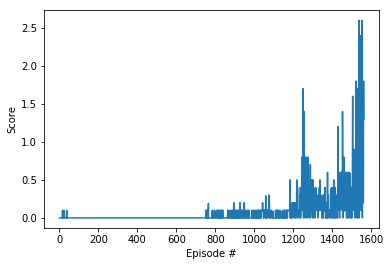

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
from agent import Agent

agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=4, mnoise=False)
agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=4, mnoise=False)

## MADDPG with separate Actor-Critic, ReplayMemory and Model

In [12]:
scores = maddpg(n_episodes=1000000, max_steps=10000, multi_agent=True, multi_replay=True, split_replay=False)

Episode:1, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:2, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:3, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:4, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:5, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:6, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:7, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:8, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:9, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:

/home/adaptation/Documents/MADDPG-Colaboration-Competition/agent.py:133: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode:34, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:35, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:36, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:37, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:38, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:39, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:40, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:41, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:42, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Avera

Episode:106, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:107, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:108, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:109, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:110, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:111, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:112, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:113, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:114, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:177, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:178, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:179, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:180, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:181, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:182, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:183, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:184, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:185, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:248, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:249, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:250, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:251, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:252, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:253, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:254, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:255, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.01
Episode:256, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:319, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:320, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:321, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:322, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:323, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:324, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:325, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:326, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:327, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:390, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:391, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:392, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:393, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:394, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:395, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:396, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:397, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.01
Episode:398, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:461, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.30, Average Score:0.02, Best Avg Score:0.02
Episode:462, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.02, Best Avg Score:0.02
Episode:463, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.02, Best Avg Score:0.02
Episode:464, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.02, Best Avg Score:0.02
Episode:465, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.02, Best Avg Score:0.02
Episode:466, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.02, Best Avg Score:0.02
Episode:467, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.30, Average Score:0.02, Best Avg Score:0.02
Episode:468, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.02, Best Avg Score:0.02
Episode:469, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30,

Episode:532, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:533, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:534, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:535, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:536, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:537, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:538, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:539, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:540, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30

Episode:603, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:604, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:605, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:606, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:607, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:608, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:609, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:610, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.05
Episode:611, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30

Episode:674, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:675, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:676, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:677, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:678, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:679, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.06, Best Avg Score:0.06
Episode:680, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.06
Episode:681, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.05, Best Avg Score:0.06
Episode:682, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30,

Episode:745, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.07, Best Avg Score:0.07
Episode:746, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.07, Best Avg Score:0.07
Episode:747, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.07, Best Avg Score:0.07
Episode:748, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.07, Best Avg Score:0.07
Episode:749, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.07, Best Avg Score:0.07
Episode:750, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.07, Best Avg Score:0.07
Episode:751, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.07, Best Avg Score:0.07
Episode:752, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:0.30, Average Score:0.07, Best Avg Score:0.07
Episode:753, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Ave

Episode:817, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.50, Average Score:0.10, Best Avg Score:0.10
Episode:818, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.10, Best Avg Score:0.10
Episode:819, Low Score:0.39, High Score:0.40, Score:0.40, Best Score:0.50, Average Score:0.11, Best Avg Score:0.11
Episode:820, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.50, Average Score:0.11, Best Avg Score:0.11
Episode:821, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.50, Average Score:0.11, Best Avg Score:0.11
Episode:822, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.50, Average Score:0.11, Best Avg Score:0.11
Episode:823, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.50, Average Score:0.11, Best Avg Score:0.11
Episode:824, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.11, Best Avg Score:0.11
Episode:825, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.50, A

Episode:888, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.13, Best Avg Score:0.13
Episode:889, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.50, Average Score:0.13, Best Avg Score:0.13
Episode:890, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.13, Best Avg Score:0.13
Episode:891, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.13, Best Avg Score:0.13
Episode:892, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.13, Best Avg Score:0.13
Episode:893, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.50, Average Score:0.13, Best Avg Score:0.13
Episode:894, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.13, Best Avg Score:0.13
Episode:895, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.50, Average Score:0.13, Best Avg Score:0.13
Episode:896, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:0.50, 

Episode:959, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:960, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:961, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:962, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:963, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:964, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:965, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:966, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:967, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.50

Episode:1030, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:0.90, Average Score:0.19, Best Avg Score:0.19
Episode:1031, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.90, Average Score:0.19, Best Avg Score:0.19
Episode:1032, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.90, Average Score:0.19, Best Avg Score:0.19
Episode:1033, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.90, Average Score:0.19, Best Avg Score:0.19
Episode:1034, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.90, Average Score:0.19, Best Avg Score:0.19
Episode:1035, Low Score:0.08, High Score:0.10, Score:0.10, Best Score:0.90, Average Score:0.18, Best Avg Score:0.19
Episode:1036, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.90, Average Score:0.18, Best Avg Score:0.19
Episode:1037, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:0.90, Average Score:0.19, Best Avg Score:0.19
Episode:1038, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0

Episode:1101, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.90, Average Score:0.18, Best Avg Score:0.19
Episode:1102, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:0.90, Average Score:0.18, Best Avg Score:0.19
Episode:1103, Low Score:0.89, High Score:0.90, Score:0.90, Best Score:0.90, Average Score:0.19, Best Avg Score:0.19
Episode:1104, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.90, Average Score:0.18, Best Avg Score:0.19
Episode:1105, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.90, Average Score:0.18, Best Avg Score:0.19
Episode:1106, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.90, Average Score:0.18, Best Avg Score:0.19
Episode:1107, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:0.90, Average Score:0.18, Best Avg Score:0.19
Episode:1108, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.90, Average Score:0.17, Best Avg Score:0.19
Episode:1109, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:

Episode:1172, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.40, Average Score:0.22, Best Avg Score:0.22
Episode:1173, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.22, Best Avg Score:0.22
Episode:1174, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.22, Best Avg Score:0.22
Episode:1175, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.22, Best Avg Score:0.22
Episode:1176, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.40, Average Score:0.22, Best Avg Score:0.22
Episode:1177, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.40, Average Score:0.22, Best Avg Score:0.22
Episode:1178, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.40, Average Score:0.22, Best Avg Score:0.22
Episode:1179, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.22, Best Avg Score:0.22
Episode:1180, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score

Episode:1243, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.22, Best Avg Score:0.24
Episode:1244, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.40, Average Score:0.22, Best Avg Score:0.24
Episode:1245, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.40, Average Score:0.22, Best Avg Score:0.24
Episode:1246, Low Score:-0.01, High Score:0.20, Score:0.20, Best Score:1.40, Average Score:0.21, Best Avg Score:0.24
Episode:1247, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.40, Average Score:0.21, Best Avg Score:0.24
Episode:1248, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.40, Average Score:0.21, Best Avg Score:0.24
Episode:1249, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.21, Best Avg Score:0.24
Episode:1250, Low Score:0.49, High Score:0.60, Score:0.60, Best Score:1.40, Average Score:0.22, Best Avg Score:0.24
Episode:1251, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:

Episode:1314, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.40, Average Score:0.20, Best Avg Score:0.24
Episode:1315, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.20, Best Avg Score:0.24
Episode:1316, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.40, Average Score:0.20, Best Avg Score:0.24
Episode:1317, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.20, Best Avg Score:0.24
Episode:1318, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.20, Best Avg Score:0.24
Episode:1319, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.20, Best Avg Score:0.24
Episode:1320, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.20, Best Avg Score:0.24
Episode:1321, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.20, Best Avg Score:0.24
Episode:1322, Low Score:-0.01, High Score:0.10, Score:0.10, Best Sco

Episode:1385, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.40, Average Score:0.24, Best Avg Score:0.24
Episode:1386, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.24, Best Avg Score:0.24
Episode:1387, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:1.40, Average Score:0.24, Best Avg Score:0.24
Episode:1388, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:1.40, Average Score:0.25, Best Avg Score:0.25
Episode:1389, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.25, Best Avg Score:0.25
Episode:1390, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.40, Average Score:0.25, Best Avg Score:0.25
Episode:1391, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.24, Best Avg Score:0.25
Episode:1392, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:1.40, Average Score:0.24, Best Avg Score:0.25
Episode:1393, Low Score:0.39, High Score:0.40, Score:0.40, Best Score:1

Episode:1456, Low Score:0.79, High Score:0.80, Score:0.80, Best Score:1.40, Average Score:0.27, Best Avg Score:0.28
Episode:1457, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:1.40, Average Score:0.27, Best Avg Score:0.28
Episode:1458, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.27, Best Avg Score:0.28
Episode:1459, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.27, Best Avg Score:0.28
Episode:1460, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.27, Best Avg Score:0.28
Episode:1461, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.27, Best Avg Score:0.28
Episode:1462, Low Score:0.20, High Score:0.29, Score:0.29, Best Score:1.40, Average Score:0.27, Best Avg Score:0.28
Episode:1463, Low Score:0.59, High Score:0.60, Score:0.60, Best Score:1.40, Average Score:0.27, Best Avg Score:0.28
Episode:1464, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1

Episode:1527, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.40, Average Score:0.28, Best Avg Score:0.28
Episode:1528, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.28, Best Avg Score:0.28
Episode:1529, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.40, Average Score:0.28, Best Avg Score:0.28
Episode:1530, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:1.40, Average Score:0.28, Best Avg Score:0.28
Episode:1531, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:1.40, Average Score:0.29, Best Avg Score:0.29
Episode:1532, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.40, Average Score:0.29, Best Avg Score:0.29
Episode:1533, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.40, Average Score:0.29, Best Avg Score:0.29
Episode:1534, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.40, Average Score:0.29, Best Avg Score:0.29
Episode:1535, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1

Episode:1598, Low Score:0.59, High Score:0.60, Score:0.60, Best Score:1.40, Average Score:0.30, Best Avg Score:0.31
Episode:1599, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.40, Average Score:0.30, Best Avg Score:0.31
Episode:1600, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:1.40, Average Score:0.30, Best Avg Score:0.31
Episode:1601, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.40, Average Score:0.30, Best Avg Score:0.31
Episode:1602, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:1.40, Average Score:0.30, Best Avg Score:0.31
Episode:1603, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.40, Average Score:0.30, Best Avg Score:0.31
Episode:1604, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.40, Average Score:0.30, Best Avg Score:0.31
Episode:1605, Low Score:0.69, High Score:0.80, Score:0.80, Best Score:1.40, Average Score:0.31, Best Avg Score:0.31
Episode:1606, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.

Episode:1669, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.35, Best Avg Score:0.35
Episode:1670, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:1.70, Average Score:0.35, Best Avg Score:0.35
Episode:1671, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.34, Best Avg Score:0.35
Episode:1672, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.34, Best Avg Score:0.35
Episode:1673, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.70, Average Score:0.34, Best Avg Score:0.35
Episode:1674, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.70, Average Score:0.34, Best Avg Score:0.35
Episode:1675, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.34, Best Avg Score:0.35
Episode:1676, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.70, Average Score:0.34, Best Avg Score:0.35
Episode:1677, Low Score:1.39, High Score:1.50, Score:1.50, Best Score:

Episode:1740, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.30, Best Avg Score:0.37
Episode:1741, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.30, Best Avg Score:0.37
Episode:1742, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.30, Best Avg Score:0.37
Episode:1743, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:1.70, Average Score:0.30, Best Avg Score:0.37
Episode:1744, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:1.70, Average Score:0.30, Best Avg Score:0.37
Episode:1745, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:1.70, Average Score:0.30, Best Avg Score:0.37
Episode:1746, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.70, Average Score:0.29, Best Avg Score:0.37
Episode:1747, Low Score:0.59, High Score:0.60, Score:0.60, Best Score:1.70, Average Score:0.30, Best Avg Score:0.37
Episode:1748, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:

Episode:1811, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.23, Best Avg Score:0.37
Episode:1812, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.23, Best Avg Score:0.37
Episode:1813, Low Score:0.49, High Score:0.60, Score:0.60, Best Score:1.70, Average Score:0.23, Best Avg Score:0.37
Episode:1814, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.23, Best Avg Score:0.37
Episode:1815, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.23, Best Avg Score:0.37
Episode:1816, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.70, Average Score:0.22, Best Avg Score:0.37
Episode:1817, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.22, Best Avg Score:0.37
Episode:1818, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.22, Best Avg Score:0.37
Episode:1819, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:1

Episode:1882, Low Score:1.09, High Score:1.10, Score:1.10, Best Score:1.70, Average Score:0.29, Best Avg Score:0.37
Episode:1883, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.29, Best Avg Score:0.37
Episode:1884, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.70, Average Score:0.30, Best Avg Score:0.37
Episode:1885, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.70, Average Score:0.30, Best Avg Score:0.37
Episode:1886, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.30, Best Avg Score:0.37
Episode:1887, Low Score:1.59, High Score:1.60, Score:1.60, Best Score:1.70, Average Score:0.31, Best Avg Score:0.37
Episode:1888, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.31, Best Avg Score:0.37
Episode:1889, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.70, Average Score:0.32, Best Avg Score:0.37
Episode:1890, Low Score:0.59, High Score:0.60, Score:0.60, Best Score:1

Episode:1953, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.42, Best Avg Score:0.43
Episode:1954, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.42, Best Avg Score:0.43
Episode:1955, Low Score:1.28, High Score:1.30, Score:1.30, Best Score:1.70, Average Score:0.43, Best Avg Score:0.43
Episode:1956, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.43, Best Avg Score:0.43
Episode:1957, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.70, Average Score:0.42, Best Avg Score:0.43
Episode:1958, Low Score:0.79, High Score:0.90, Score:0.90, Best Score:1.70, Average Score:0.43, Best Avg Score:0.43
Episode:1959, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.70, Average Score:0.42, Best Avg Score:0.43
Episode:1960, Low Score:0.20, High Score:0.29, Score:0.29, Best Score:1.70, Average Score:0.42, Best Avg Score:0.43
Episode:1961, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:

Episode:2024, Low Score:0.69, High Score:0.70, Score:0.70, Best Score:2.50, Average Score:0.44, Best Avg Score:0.44
Episode:2025, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:2.50, Average Score:0.44, Best Avg Score:0.44
Episode:2026, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:2.50, Average Score:0.44, Best Avg Score:0.44
Episode:2027, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:2.50, Average Score:0.44, Best Avg Score:0.44
Episode:2028, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:2.50, Average Score:0.44, Best Avg Score:0.44
Episode:2029, Low Score:0.40, High Score:0.49, Score:0.49, Best Score:2.50, Average Score:0.44, Best Avg Score:0.44
Episode:2030, Low Score:0.40, High Score:0.49, Score:0.49, Best Score:2.50, Average Score:0.44, Best Avg Score:0.44
Episode:2031, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:2.50, Average Score:0.42, Best Avg Score:0.44
Episode:2032, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:2.

Episode:2095, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:2.60, Average Score:0.40, Best Avg Score:0.44
Episode:2096, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:2.60, Average Score:0.40, Best Avg Score:0.44
Episode:2097, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:2.60, Average Score:0.39, Best Avg Score:0.44
Episode:2098, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:2.60, Average Score:0.39, Best Avg Score:0.44
Episode:2099, Low Score:0.59, High Score:0.60, Score:0.60, Best Score:2.60, Average Score:0.39, Best Avg Score:0.44
Episode:2100, Low Score:0.99, High Score:1.10, Score:1.10, Best Score:2.60, Average Score:0.40, Best Avg Score:0.44
Episode:2101, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:2.60, Average Score:0.40, Best Avg Score:0.44
Episode:2102, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:2.60, Average Score:0.37, Best Avg Score:0.44
Episode:2103, Low Score:0.69, High Score:0.70, Score:0.70, Best Score

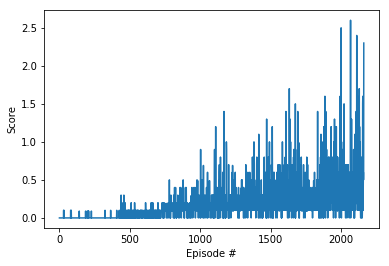

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## MADDPG with Separate Actor-Critic,  Indvidual State, ReplayMemory and Model

In [14]:
from agent import Agent

agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=4, mnoise=False, split_state=False)
agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=4, mnoise=False, split_state=False)


In [15]:
scores = maddpg(n_episodes=1000000, max_steps=10000, multi_agent=True, multi_replay=True, split_replay=True)

Episode:1, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:2, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:3, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:4, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:5, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:6, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:7, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:8, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:9, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:

/home/adaptation/Documents/MADDPG-Colaboration-Competition/agent.py:133: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode:65, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:66, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:67, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:68, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:69, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:70, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:71, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:72, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:73, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Avera

Episode:136, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.02
Episode:137, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.02
Episode:138, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.02
Episode:139, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.02
Episode:140, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.02
Episode:141, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.02
Episode:142, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.02
Episode:143, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.02
Episode:144, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:207, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:208, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:209, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:210, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:211, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:212, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:213, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:214, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:215, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:278, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:279, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:280, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:281, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:282, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:283, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:284, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:285, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:286, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.2

Episode:349, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:350, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:351, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:352, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:353, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:354, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:355, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:356, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:357, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:420, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:421, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:422, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:423, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:424, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:425, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:426, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:427, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.02
Episode:428, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:491, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:492, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:493, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:494, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:495, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:496, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:497, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:498, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:499, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:562, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:563, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:564, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:565, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:566, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:567, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:568, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:569, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.02
Episode:570, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:633, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:634, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:635, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:636, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:637, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:638, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:639, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:640, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:641, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.2

Episode:704, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:705, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:706, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:707, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:708, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:709, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:710, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:711, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:712, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:775, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:776, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:777, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:778, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:779, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:780, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:781, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:782, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:783, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.2

Episode:846, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:847, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:848, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:849, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:850, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:851, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:852, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:853, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:854, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.2

Episode:917, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:918, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:919, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:920, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:921, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:922, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:923, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:924, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:925, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.2

Episode:988, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:989, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:990, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:991, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:992, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:993, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:994, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:995, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:996, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.2

Episode:1059, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:1060, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:1061, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:1062, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:1063, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:1064, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:1065, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:1066, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:1067, Low Score:-0.01, High Score:0.00, Score:0.00, Best 

Episode:1130, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:1131, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:1132, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:1133, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:1134, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:1135, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:1136, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:1137, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:1138, Low Score:-0.01, High Score:0.00, Score:0.00, Best Sc

Episode:1201, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:1202, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:1203, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:1204, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:1205, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:1206, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:1207, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:1208, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:1209, Low Score:0.00, High Score:0.09, Score:0.09, Best Sc

Episode:1272, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1273, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1274, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1275, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1276, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1277, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1278, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1279, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1280, Low Score:-0.01, High Score:0.10, Score:0.10, Best S

Episode:1343, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1344, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1345, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1346, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1347, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1348, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1349, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1350, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.05, Best Avg Score:0.06
Episode:1351, Low Score:0.00, High Score:0.09, Score:0.09, Best Sco

Episode:1414, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.07, Best Avg Score:0.07
Episode:1415, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.07, Best Avg Score:0.07
Episode:1416, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.07, Best Avg Score:0.07
Episode:1417, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.07, Best Avg Score:0.07
Episode:1418, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.07, Best Avg Score:0.07
Episode:1419, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.07, Best Avg Score:0.07
Episode:1420, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.07, Best Avg Score:0.07
Episode:1421, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.07, Best Avg Score:0.07
Episode:1422, Low Score:-0.01, High Score:0.00, Score:0.00, Best 

Episode:1485, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:0.30, Average Score:0.09, Best Avg Score:0.09
Episode:1486, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.09
Episode:1487, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.30, Average Score:0.09, Best Avg Score:0.09
Episode:1488, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.09, Best Avg Score:0.09
Episode:1489, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.09, Best Avg Score:0.09
Episode:1490, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.09, Best Avg Score:0.09
Episode:1491, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.09
Episode:1492, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.09
Episode:1493, Low Score:-0.01, High Score:0.10, Score:0.10, Best Scor

Episode:1556, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1557, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1558, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1559, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1560, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1561, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1562, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1563, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1564, Low Score:0.09, High Score:0.20, Score:0.20, Best Sc

Episode:1627, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1628, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1629, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1630, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1631, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1632, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1633, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1634, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.09, Best Avg Score:0.10
Episode:1635, Low Score:0.00, High Score:0.09, Score:0.09, Best Scor

Episode:1698, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:1699, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:1700, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:1701, Low Score:0.18, High Score:0.30, Score:0.30, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:1702, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.30, Average Score:0.11, Best Avg Score:0.11
Episode:1703, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.11, Best Avg Score:0.11
Episode:1704, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.11, Best Avg Score:0.11
Episode:1705, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.11, Best Avg Score:0.11
Episode:1706, Low Score:0.19, High Score:0.20, Score:0.20, Best Sco

Episode:1769, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.30, Average Score:0.12, Best Avg Score:0.12
Episode:1770, Low Score:0.08, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.12, Best Avg Score:0.12
Episode:1771, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.12, Best Avg Score:0.12
Episode:1772, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.12, Best Avg Score:0.12
Episode:1773, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.12, Best Avg Score:0.12
Episode:1774, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.12, Best Avg Score:0.12
Episode:1775, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.11, Best Avg Score:0.12
Episode:1776, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.11, Best Avg Score:0.12
Episode:1777, Low Score:0.09, High Score:0.20, Score:0.20, Best Scor

Episode:1840, Low Score:0.49, High Score:0.50, Score:0.50, Best Score:0.70, Average Score:0.13, Best Avg Score:0.13
Episode:1841, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.13, Best Avg Score:0.13
Episode:1842, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.13, Best Avg Score:0.13
Episode:1843, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.13, Best Avg Score:0.13
Episode:1844, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.13, Best Avg Score:0.13
Episode:1845, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.13, Best Avg Score:0.13
Episode:1846, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:0.70, Average Score:0.13, Best Avg Score:0.13
Episode:1847, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.70, Average Score:0.13, Best Avg Score:0.13
Episode:1848, Low Score:-0.01, High Score:0.10, Score:0.10, Best Sc

Episode:1911, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.14, Best Avg Score:0.14
Episode:1912, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.14, Best Avg Score:0.14
Episode:1913, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.14, Best Avg Score:0.14
Episode:1914, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.70, Average Score:0.14, Best Avg Score:0.14
Episode:1915, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.14, Best Avg Score:0.14
Episode:1916, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.14, Best Avg Score:0.14
Episode:1917, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:0.70, Average Score:0.14, Best Avg Score:0.14
Episode:1918, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.70, Average Score:0.14, Best Avg Score:0.14
Episode:1919, Low Score:0.19, High Score:0.20, Score:0.20, Best Sco

Episode:1982, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.15, Best Avg Score:0.15
Episode:1983, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.15, Best Avg Score:0.15
Episode:1984, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.70, Average Score:0.14, Best Avg Score:0.15
Episode:1985, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.15, Best Avg Score:0.15
Episode:1986, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.15, Best Avg Score:0.15
Episode:1987, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:0.70, Average Score:0.15, Best Avg Score:0.15
Episode:1988, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.15, Best Avg Score:0.15
Episode:1989, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.15, Best Avg Score:0.15
Episode:1990, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score

Episode:2053, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.16, Best Avg Score:0.16
Episode:2054, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.16, Best Avg Score:0.16
Episode:2055, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.16, Best Avg Score:0.16
Episode:2056, Low Score:0.49, High Score:0.50, Score:0.50, Best Score:0.70, Average Score:0.17, Best Avg Score:0.17
Episode:2057, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:0.70, Average Score:0.17, Best Avg Score:0.17
Episode:2058, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.17, Best Avg Score:0.17
Episode:2059, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:0.70, Average Score:0.17, Best Avg Score:0.17
Episode:2060, Low Score:0.79, High Score:0.90, Score:0.90, Best Score:0.90, Average Score:0.18, Best Avg Score:0.18
Episode:2061, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0

Episode:2124, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.10, Average Score:0.27, Best Avg Score:0.27
Episode:2125, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.10, Average Score:0.27, Best Avg Score:0.27
Episode:2126, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:1.10, Average Score:0.26, Best Avg Score:0.27
Episode:2127, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.10, Average Score:0.26, Best Avg Score:0.27
Episode:2128, Low Score:0.39, High Score:0.40, Score:0.40, Best Score:1.10, Average Score:0.27, Best Avg Score:0.27
Episode:2129, Low Score:0.39, High Score:0.40, Score:0.40, Best Score:1.10, Average Score:0.27, Best Avg Score:0.27
Episode:2130, Low Score:0.49, High Score:0.60, Score:0.60, Best Score:1.10, Average Score:0.27, Best Avg Score:0.27
Episode:2131, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.10, Average Score:0.27, Best Avg Score:0.27
Episode:2132, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:

Episode:2195, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2196, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2197, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2198, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2199, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.60, Average Score:0.24, Best Avg Score:0.27
Episode:2200, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.60, Average Score:0.24, Best Avg Score:0.27
Episode:2201, Low Score:0.59, High Score:0.60, Score:0.60, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2202, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.60, Average Score:0.24, Best Avg Score:0.27
Episode:2203, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score

Episode:2266, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2267, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2268, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2269, Low Score:0.39, High Score:0.40, Score:0.40, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2270, Low Score:0.40, High Score:0.49, Score:0.49, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2271, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:1.60, Average Score:0.25, Best Avg Score:0.27
Episode:2272, Low Score:0.89, High Score:1.00, Score:1.00, Best Score:1.60, Average Score:0.26, Best Avg Score:0.27
Episode:2273, Low Score:0.49, High Score:0.50, Score:0.50, Best Score:1.60, Average Score:0.27, Best Avg Score:0.27
Episode:2274, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1

Episode:2337, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:1.60, Average Score:0.34, Best Avg Score:0.34
Episode:2338, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:1.60, Average Score:0.34, Best Avg Score:0.34
Episode:2339, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.60, Average Score:0.34, Best Avg Score:0.34
Episode:2340, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.60, Average Score:0.34, Best Avg Score:0.34
Episode:2341, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.60, Average Score:0.33, Best Avg Score:0.34
Episode:2342, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:1.60, Average Score:0.33, Best Avg Score:0.34
Episode:2343, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.60, Average Score:0.33, Best Avg Score:0.34
Episode:2344, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.60, Average Score:0.33, Best Avg Score:0.34
Episode:2345, Low Score:0.79, High Score:0.90, Score:0.90, Best Score:

Episode:2408, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.60, Average Score:0.32, Best Avg Score:0.35
Episode:2409, Low Score:0.59, High Score:0.60, Score:0.60, Best Score:1.60, Average Score:0.33, Best Avg Score:0.35
Episode:2410, Low Score:0.69, High Score:0.70, Score:0.70, Best Score:1.60, Average Score:0.34, Best Avg Score:0.35
Episode:2411, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.60, Average Score:0.33, Best Avg Score:0.35
Episode:2412, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.60, Average Score:0.33, Best Avg Score:0.35
Episode:2413, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.60, Average Score:0.33, Best Avg Score:0.35
Episode:2414, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.60, Average Score:0.33, Best Avg Score:0.35
Episode:2415, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.60, Average Score:0.33, Best Avg Score:0.35
Episode:2416, Low Score:1.79, High Score:1.90, Score:1.90, Best Score:

Episode:2479, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2480, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2481, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2482, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2483, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.90, Average Score:0.32, Best Avg Score:0.37
Episode:2484, Low Score:0.39, High Score:0.40, Score:0.40, Best Score:1.90, Average Score:0.32, Best Avg Score:0.37
Episode:2485, Low Score:1.39, High Score:1.50, Score:1.50, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2486, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2487, Low Score:0.09, High Score:0.20, Score:0.20, Best Score

Episode:2550, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:1.90, Average Score:0.35, Best Avg Score:0.37
Episode:2551, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.90, Average Score:0.35, Best Avg Score:0.37
Episode:2552, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.90, Average Score:0.34, Best Avg Score:0.37
Episode:2553, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2554, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2555, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2556, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.90, Average Score:0.32, Best Avg Score:0.37
Episode:2557, Low Score:1.29, High Score:1.30, Score:1.30, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2558, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:

Episode:2621, Low Score:0.79, High Score:0.80, Score:0.80, Best Score:1.90, Average Score:0.33, Best Avg Score:0.37
Episode:2622, Low Score:0.59, High Score:0.60, Score:0.60, Best Score:1.90, Average Score:0.34, Best Avg Score:0.37
Episode:2623, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:1.90, Average Score:0.34, Best Avg Score:0.37
Episode:2624, Low Score:0.49, High Score:0.50, Score:0.50, Best Score:1.90, Average Score:0.34, Best Avg Score:0.37
Episode:2625, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.90, Average Score:0.34, Best Avg Score:0.37
Episode:2626, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:1.90, Average Score:0.34, Best Avg Score:0.37
Episode:2627, Low Score:0.40, High Score:0.49, Score:0.49, Best Score:1.90, Average Score:0.34, Best Avg Score:0.37
Episode:2628, Low Score:0.40, High Score:0.49, Score:0.49, Best Score:1.90, Average Score:0.34, Best Avg Score:0.37
Episode:2629, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:1

Episode:2692, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:2.00, Average Score:0.40, Best Avg Score:0.40
Episode:2693, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:2.00, Average Score:0.40, Best Avg Score:0.40
Episode:2694, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:2.00, Average Score:0.39, Best Avg Score:0.40
Episode:2695, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:2.00, Average Score:0.40, Best Avg Score:0.40
Episode:2696, Low Score:0.59, High Score:0.70, Score:0.70, Best Score:2.00, Average Score:0.40, Best Avg Score:0.40
Episode:2697, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:2.00, Average Score:0.40, Best Avg Score:0.40
Episode:2698, Low Score:0.79, High Score:0.80, Score:0.80, Best Score:2.00, Average Score:0.40, Best Avg Score:0.40
Episode:2699, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:2.00, Average Score:0.40, Best Avg Score:0.40
Episode:2700, Low Score:0.19, High Score:0.20, Score:0.20, Best Scor

Episode:2763, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:2.00, Average Score:0.37, Best Avg Score:0.41
Episode:2764, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:2.00, Average Score:0.37, Best Avg Score:0.41
Episode:2765, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:2.00, Average Score:0.38, Best Avg Score:0.41
Episode:2766, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:2.00, Average Score:0.38, Best Avg Score:0.41
Episode:2767, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:2.00, Average Score:0.36, Best Avg Score:0.41
Episode:2768, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:2.00, Average Score:0.36, Best Avg Score:0.41
Episode:2769, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:2.00, Average Score:0.36, Best Avg Score:0.41
Episode:2770, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:2.00, Average Score:0.35, Best Avg Score:0.41
Episode:2771, Low Score:1.09, High Score:1.10, Score:1.10, Best Score:2.

Episode:2834, Low Score:1.59, High Score:1.70, Score:1.70, Best Score:2.60, Average Score:0.40, Best Avg Score:0.41
Episode:2835, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:2.60, Average Score:0.40, Best Avg Score:0.41
Episode:2836, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:2.60, Average Score:0.39, Best Avg Score:0.41
Episode:2837, Low Score:1.19, High Score:1.20, Score:1.20, Best Score:2.60, Average Score:0.40, Best Avg Score:0.41
Episode:2838, Low Score:1.09, High Score:1.10, Score:1.10, Best Score:2.60, Average Score:0.41, Best Avg Score:0.41
Episode:2839, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:2.60, Average Score:0.41, Best Avg Score:0.41
Episode:2840, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:2.60, Average Score:0.41, Best Avg Score:0.41
Episode:2841, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:2.60, Average Score:0.40, Best Avg Score:0.41
Episode:2842, Low Score:1.59, High Score:1.70, Score:1.70, Best Score

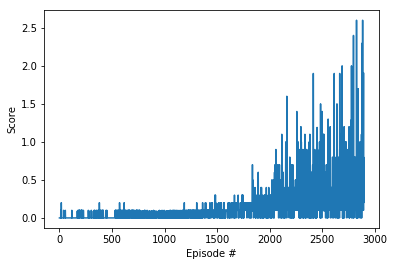

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 9 Load the saved weights for the network

In [17]:
from agent import Agent

agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=4, mnoise=False, split_state=False)

In [22]:
agent1.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent1.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

## 10: Now sit back and watch some Tennis .

In [24]:
# watch the Master agent
def maddpg(n_episodes=1, max_steps=1000):
    scores_hundred_queue = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations            
        scores_agents = np.zeros(num_agents)             
        agent1.reset()
        score = 0
        for step in range(max_steps):
            actions = agent1.act(states)
            env_info = env.step(actions)[brain_name]     
            next_states = env_info.vector_observations   
            rewards = env_info.rewards                   
            dones = env_info.local_done                  
            agent1.step(states, actions, rewards, next_states, dones, step)
            states = next_states
            scores_agents += rewards
            if np.any(dones):
                break
        score = score = scores_agents.max()
        scores.append(score)        
        print("Episode: ", i_episode)
        print("Score: {:.2f}".format(score))
    
       
        
      
    return scores

scores = maddpg()

Episode:  1
Score: 1.80


In [ ]:
env.close()